# Part 1. Install Packages

In [1]:
## install required packages
!pip install swig
!pip install wrds
!pip install pyportfolioopt
## install finrl library
!pip install -q condacolab
import condacolab
condacolab.install()
!apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git#egg=FinRL

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 21.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 58.9 MB/s eta 0:00:00
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 2.0.9
    Uninstalling SQLAlchemy-2.0.9:
      Successfully uninstalled SQLAlchemy-2.0.9
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 2.5 MB/s eta 0:00:00
⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:17
🔁 Restarting ker

In [1]:
import os
import itertools
import sys

import pandas as pd
import numpy as np
import datetime
import yfinance as yf
import matplotlib.pyplot as plt
%matplotlib inline

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.config import INDICATORS
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3.common.logger import configure
from finrl import config_tickers
from finrl.main import check_and_make_directories
from finrl.config import INDICATORS, TRAINED_MODEL_DIR, RESULTS_DIR
from stable_baselines3 import A2C, DDPG, PPO, SAC, TD3
from finrl.config import INDICATORS

check_and_make_directories([TRAINED_MODEL_DIR])

# Part 2. Fetch data

[yfinance](https://github.com/ranaroussi/yfinance) is an open-source library that provides APIs fetching historical data form Yahoo Finance. In FinRL, we have a class called [YahooDownloader](https://github.com/AI4Finance-Foundation/FinRL/blob/master/finrl/meta/preprocessor/yahoodownloader.py) that use yfinance to fetch data from Yahoo Finance.

**OHLCV**: Data downloaded are in the form of OHLCV, corresponding to **open, high, low, close, volume,** respectively. OHLCV is important because they contain most of numerical information of a stock in time series. From OHLCV, traders can get further judgement and prediction like the momentum, people's interest, market trends, etc.

## Data for a single ticker

Here we provide two ways to fetch data with single ticker, let's take Apple Inc. (AAPL) as an example.

### Using yfinance

In [2]:
aapl_df_yf = yf.download(tickers = "aapl", start='2020-01-01', end='2020-01-31')

[*********************100%***********************]  1 of 1 completed


In [3]:
aapl_df_yf.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,74.059998,75.150002,73.797501,75.087502,73.449387,135480400
2020-01-03,74.287498,75.144997,74.125000,74.357498,72.735313,146322800
2020-01-06,73.447502,74.989998,73.187500,74.949997,73.314880,118387200
2020-01-07,74.959999,75.224998,74.370003,74.597504,72.970078,108872000
2020-01-08,74.290001,76.110001,74.290001,75.797501,74.143906,132079200


### Using FinRL

In FinRL's YahooDownloader, we modified the data frame to the form that convenient for further data processing process. We use adjusted close price instead of close price, and add a column representing the day of a week (0-4 corresponding to Monday-Friday).

In [4]:
aapl_df_finrl = YahooDownloader(start_date = '2020-01-01',
                                end_date = '2020-01-31',
                                ticker_list = ['aapl']).fetch_data()

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (20, 8)


In [5]:
aapl_df_finrl.head()

,date,open,high,low,close,volume,tic,day
0,2020-01-02,74.059998,75.150002,73.797501,73.449387,135480400,aapl,3
1,2020-01-03,74.287498,75.144997,74.125000,72.735306,146322800,aapl,4
2,2020-01-06,73.447502,74.989998,73.187500,73.314880,118387200,aapl,0
3,2020-01-07,74.959999,75.224998,74.370003,72.970093,108872000,aapl,1
4,2020-01-08,74.290001,76.110001,74.290001,74.143898,132079200,aapl,2


## Data for the chosen tickers

In [6]:
config_tickers.DOW_30_TICKER

['AXP',
 'AMGN',
 'AAPL',
 'BA',
 'CAT',
 'CSCO',
 'CVX',
 'GS',
 'HD',
 'HON',
 'IBM',
 'INTC',
 'JNJ',
 'KO',
 'JPM',
 'MCD',
 'MMM',
 'MRK',
 'MSFT',
 'NKE',
 'PG',
 'TRV',
 'UNH',
 'CRM',
 'VZ',
 'V',
 'WBA',
 'WMT',
 'DIS',
 'DOW']

In [7]:
TRAIN_START_DATE = '2009-01-01'
TRAIN_END_DATE = '2020-07-01'
TRADE_START_DATE = '2020-07-01'
TRADE_END_DATE = '2021-10-29'

In [8]:
df_raw = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TRADE_END_DATE,
                     ticker_list = config_tickers.DOW_30_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [9]:
df_raw.head()

,date,open,high,low,close,volume,tic,day
0,2009-01-02,3.067143,3.251429,3.041429,2.758536,746015200,AAPL,4
1,2009-01-02,58.590000,59.080002,57.750000,43.832630,6547900,AMGN,4
2,2009-01-02,18.570000,19.520000,18.400000,15.308588,10955700,AXP,4
3,2009-01-02,42.799999,45.560001,42.779999,33.941093,7010200,BA,4
4,2009-01-02,44.910000,46.980000,44.709999,31.408842,7117200,CAT,4


# Part 3: Preprocess Data
We need to check for missing data and do feature engineering to convert the data point into a state.
* **Adding technical indicators**. In practical trading, various information needs to be taken into account, such as historical prices, current holding shares, technical indicators, etc. Here, we demonstrate two trend-following technical indicators: MACD and RSI.
* **Adding turbulence index**. Risk-aversion reflects whether an investor prefers to protect the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the turbulence index that measures extreme fluctuation of asset price.

Hear let's take **MACD** as an example. Moving average convergence/divergence (MACD) is one of the most commonly used indicator showing bull and bear market. Its calculation is based on EMA (Exponential Moving Average indicator, measuring trend direction over a period of time.)

In [10]:
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_vix=True,
                     use_turbulence=True,
                     user_defined_feature = False)

processed = fe.preprocess_data(df_raw)

Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (3228, 8)
Successfully added vix
Successfully added turbulence index


In [11]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

In [12]:
processed_full.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2009-01-02,AAPL,3.067143,3.251429,3.041429,2.758536,746015200.0,4.0,0.0,2.981389,2.652103,100.0,66.666667,100.0,2.758536,2.758536,39.189999,0.0
1,2009-01-02,AMGN,58.590000,59.080002,57.750000,43.832630,6547900.0,4.0,0.0,2.981389,2.652103,100.0,66.666667,100.0,43.832630,43.832630,39.189999,0.0
2,2009-01-02,AXP,18.570000,19.520000,18.400000,15.308588,10955700.0,4.0,0.0,2.981389,2.652103,100.0,66.666667,100.0,15.308588,15.308588,39.189999,0.0
3,2009-01-02,BA,42.799999,45.560001,42.779999,33.941093,7010200.0,4.0,0.0,2.981389,2.652103,100.0,66.666667,100.0,33.941093,33.941093,39.189999,0.0
4,2009-01-02,CAT,44.910000,46.980000,44.709999,31.408842,7117200.0,4.0,0.0,2.981389,2.652103,100.0,66.666667,100.0,31.408842,31.408842,39.189999,0.0


### Split the data for training and trading

In [13]:
train = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE)
print(len(train))
print(len(trade))

83897
9715


# Part 4. Environment

In [14]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 29, State Space: 291


In [15]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}


e_train_gym = StockTradingEnv(df = train, **env_kwargs)

Training environment

In [16]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


# Part 5. Train DRL agents

In [142]:
agent = DRLAgent(env = env_train)

# Set the corresponding values to 'True' for the algorithms that you want to use
if_using_a2c = True
if_using_ddpg = True
if_using_ppo = False
if_using_td3 = False
if_using_sac = True

### A2C

In [152]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

if if_using_a2c:
  # set up logger
  tmp_path = RESULTS_DIR + '/a2c'
  new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_a2c.set_logger(new_logger_a2c)

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device
Logging to results/a2c


In [ ]:
trained_a2c = agent.train_model(model=model_a2c, 
                             tb_log_name='a2c',
                             total_timesteps=80000) if if_using_a2c else None

--------------------------------------
| time/                 |            |
|    fps                | 43         |
|    iterations         | 100        |
|    time_elapsed       | 11         |
|    total_timesteps    | 500        |
| train/                |            |
|    entropy_loss       | -41.4      |
|    explained_variance | -0.422     |
|    learning_rate      | 0.0007     |
|    n_updates          | 99         |
|    policy_loss        | -45.5      |
|    reward             | 0.13854198 |
|    std                | 1.01       |
|    value_loss         | 2.36       |
--------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 56         |
|    iterations         | 200        |
|    time_elapsed       | 17         |
|    total_timesteps    | 1000       |
| train/                |            |
|    entropy_loss       | -41.4      |
|    explained_variance | -0.0149    |
|    learning_rate      |

### DDPG

In [23]:
agent = DRLAgent(env = env_train)
DDPG_PARAMS = {
    "learning_rate": 0.0001,
}
model_ddpg = agent.get_model("ddpg",model_kwargs = DDPG_PARAMS)

if if_using_ddpg:
  # set up logger
  tmp_path = RESULTS_DIR + '/ddpg'
  new_logger_ddpg = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ddpg.set_logger(new_logger_ddpg)

{'learning_rate': 0.0001}
Using cpu device
Logging to results/ddpg


In [24]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=50000) if if_using_ddpg else None

day: 2892, episode: 20
begin_total_asset: 1000000.00
end_total_asset: 3956012.29
total_reward: 2956012.29
total_cost: 999.00
total_trades: 46272
Sharpe: 0.700
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 25        |
|    time_elapsed    | 449       |
|    total_timesteps | 11572     |
| train/             |           |
|    actor_loss      | -47.8     |
|    critic_loss     | 1.37e+03  |
|    learning_rate   | 0.0001    |
|    n_updates       | 8679      |
|    reward          | 3.4657168 |
----------------------------------
----------------------------------
| time/              |           |
|    episodes        | 8         |
|    fps             | 22        |
|    time_elapsed    | 1008      |
|    total_timesteps | 23144     |
| train/             |           |
|    actor_loss      | -44       |
|    critic_loss     | 70.9      |
|    learning_rate   | 0.0001    |
|    n_updates       | 20251     |
|

### PPO

In [25]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.000075,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

if if_using_ppo:
  # set up logger
  tmp_path = RESULTS_DIR + '/ppo'
  new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ppo.set_logger(new_logger_ppo)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 7.5e-05, 'batch_size': 128}
Using cpu device


In [26]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=75000) if if_using_ppo else None

### TD3

In [27]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100, 
              "buffer_size": 1000000, 
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

if if_using_td3:
  # set up logger
  tmp_path = RESULTS_DIR + '/td3'
  new_logger_td3 = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_td3.set_logger(new_logger_td3)

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device


In [28]:
trained_td3 = agent.train_model(model=model_td3, 
                             tb_log_name='td3',
                             total_timesteps=50000) if if_using_td3 else None

### SAC

In [29]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

if if_using_sac:
  # set up logger
  tmp_path = RESULTS_DIR + '/sac'
  new_logger_sac = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_sac.set_logger(new_logger_sac)

{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cpu device
Logging to results/sac


In [30]:
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=75000) if if_using_sac else None

-----------------------------------
| time/              |            |
|    episodes        | 4          |
|    fps             | 18         |
|    time_elapsed    | 619        |
|    total_timesteps | 11572      |
| train/             |            |
|    actor_loss      | 1.05e+03   |
|    critic_loss     | 95.8       |
|    ent_coef        | 0.224      |
|    ent_coef_loss   | -45        |
|    learning_rate   | 0.0001     |
|    n_updates       | 11471      |
|    reward          | -3.9904697 |
-----------------------------------
day: 2892, episode: 40
begin_total_asset: 1000000.00
end_total_asset: 3805699.98
total_reward: 2805699.98
total_cost: 197137.55
total_trades: 73282
Sharpe: 0.575
-----------------------------------
| time/              |            |
|    episodes        | 8          |
|    fps             | 18         |
|    time_elapsed    | 1255       |
|    total_timesteps | 23144      |
| train/             |            |
|    actor_loss      | 497        |
|    criti

# Part 6. Backtesting

In [145]:
stock_dimension = len(trade.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 29, State Space: 291


In [146]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}

In [147]:
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)

### Backtest agents

In [148]:
df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
    model=trained_a2c, 
    environment = e_trade_gym) if if_using_a2c else (None, None)

df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(
    model=trained_ddpg, 
    environment = e_trade_gym) if if_using_ddpg else (None, None)  

df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
    model=trained_ppo, 
    environment = e_trade_gym) if if_using_ppo else (None, None)

df_account_value_td3, df_actions_td3 = DRLAgent.DRL_prediction(
    model=trained_td3, 
    environment = e_trade_gym) if if_using_td3 else (None, None)

df_account_value_sac, df_actions_sac = DRLAgent.DRL_prediction(
    model=trained_sac, 
    environment = e_trade_gym) if if_using_sac else (None, None)

hit end!
hit end!
hit end!


# Part 7. Mean Variance Optimization

In [35]:
# Codes in this section partially refer to Dr G A Vijayalakshmi Pai

# https://www.kaggle.com/code/vijipai/lesson-5-mean-variance-optimization-of-portfolios/notebook

def process_df_for_mvo(df):
  df = df.sort_values(['date','tic'],ignore_index=True)[['date','tic','close']]
  fst = df
  fst = fst.iloc[0:stock_dimension, :]
  tic = fst['tic'].tolist()

  mvo = pd.DataFrame()

  for k in range(len(tic)):
    mvo[tic[k]] = 0

  for i in range(df.shape[0]//stock_dimension):
    n = df
    n = n.iloc[i * stock_dimension:(i+1) * stock_dimension, :]
    date = n['date'][i*stock_dimension]
    mvo.loc[date] = n['close'].tolist()
  
  return mvo


def StockReturnsComputing(StockPrice, Rows, Columns): 
  import numpy as np 
  StockReturn = np.zeros([Rows-1, Columns]) 
  for j in range(Columns):        # j: Assets 
    for i in range(Rows-1):     # i: Daily Prices 
      StockReturn[i,j]=((StockPrice[i+1, j]-StockPrice[i,j])/StockPrice[i,j])* 100 
      
  return StockReturn

In [36]:
train_mvo = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE).reset_index()
trade_mvo = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE).reset_index()

In [37]:
StockData = process_df_for_mvo(train_mvo)
TradeData = process_df_for_mvo(trade_mvo)

TradeData.to_numpy()

array([[ 89.49456024, 234.61431885,  90.74229431, ...,  46.98942947,
         36.29002762, 114.62763977],
       [ 89.49456024, 237.48356628,  91.01244354, ...,  47.09257126,
         37.26651764, 114.16796112],
       [ 91.88856506, 235.65353394,  93.18331146, ...,  47.47935486,
         38.31402969, 113.86148071],
       ...,
       [147.34196472, 197.85211182, 178.69204712, ...,  48.2805481 ,
         45.98464584, 146.54457092],
       [148.01605225, 198.85264587, 177.35900879, ...,  48.73966217,
         45.13446808, 145.26527405],
       [147.55014038, 196.85154724, 174.4969635 , ...,  48.32645416,
         44.022686  , 144.07385254]])

In [38]:
#compute asset returns
arStockPrices = np.asarray(StockData)
[Rows, Cols]=arStockPrices.shape
arReturns = StockReturnsComputing(arStockPrices, Rows, Cols)

#compute mean returns and variance covariance matrix of returns
meanReturns = np.mean(arReturns, axis = 0)
covReturns = np.cov(arReturns, rowvar=False)
 
#set precision for printing results
np.set_printoptions(precision=3, suppress = True)

#display mean returns and variance-covariance matrix of returns
print('Mean returns of assets in k-portfolio 1\n', meanReturns)
print('Variance-Covariance matrix of returns\n', covReturns)

Mean returns of assets in k-portfolio 1
 [0.136 0.068 0.086 0.083 0.066 0.134 0.06  0.035 0.072 0.056 0.103 0.073
 0.033 0.076 0.047 0.073 0.042 0.056 0.054 0.056 0.103 0.089 0.041 0.053
 0.104 0.11  0.044 0.042 0.042]
Variance-Covariance matrix of returns
 [[3.156 1.066 1.768 1.669 1.722 1.814 1.569 1.302 1.302 1.811 1.303 1.432
  1.218 1.674 0.74  1.839 0.719 0.884 1.241 0.823 1.561 1.324 0.752 1.027
  1.298 1.466 0.657 1.078 0.631]
 [1.066 2.571 1.306 1.123 1.193 1.319 1.116 1.053 1.045 1.269 1.068 1.089
  0.899 1.218 0.926 1.391 0.682 0.727 1.025 1.156 1.166 0.984 0.798 0.956
  1.259 1.111 0.688 1.091 0.682]
 [1.768 1.306 4.847 2.73  2.6   2.128 1.944 2.141 2.17  3.142 1.932 2.283
  1.56  2.012 0.993 3.707 1.094 1.319 1.845 1.236 1.899 1.894 1.041 1.921
  1.823 2.314 0.986 1.421 0.707]
 [1.669 1.123 2.73  4.892 2.363 1.979 1.7   2.115 1.959 2.387 1.773 2.319
  1.571 1.797 0.968 2.597 1.144 1.298 1.643 1.071 1.615 1.775 0.91  1.666
  1.707 1.784 0.82  1.345 0.647]
 [1.722 1.193 2.6 

In [39]:
from pypfopt.efficient_frontier import EfficientFrontier

ef_mean = EfficientFrontier(meanReturns, covReturns, weight_bounds=(0, 0.5))
raw_weights_mean = ef_mean.max_sharpe()
cleaned_weights_mean = ef_mean.clean_weights()
mvo_weights = np.array([1000000 * cleaned_weights_mean[i] for i in range(29)])
mvo_weights

array([424250.,      0.,      0.,      0.,      0., 108650.,      0.,
            0.,      0.,      0., 181450.,      0.,      0.,      0.,
            0.,      0.,      0.,      0.,      0.,      0.,  16960.,
            0.,      0.,      0., 133540., 135150.,      0.,      0.,
            0.])

In [40]:
LastPrice = np.array([1/p for p in StockData.tail(1).to_numpy()[0]])
Initial_Portfolio = np.multiply(mvo_weights, LastPrice)
Initial_Portfolio

array([4731.546,    0.   ,    0.   ,    0.   ,    0.   ,  579.993,
          0.   ,    0.   ,    0.   ,    0.   ,  771.759,    0.   ,
          0.   ,    0.   ,    0.   ,    0.   ,    0.   ,    0.   ,
          0.   ,    0.   ,   85.465,    0.   ,    0.   ,    0.   ,
        470.265,  712.801,    0.   ,    0.   ,    0.   ])

In [41]:
Portfolio_Assets = TradeData @ Initial_Portfolio
MVO_result = pd.DataFrame(Portfolio_Assets, columns=["Mean Var"])
# MVO_result

# Part 8. DJIA index

In [42]:
df_dji = YahooDownloader(start_date = TRADE_START_DATE,
                     end_date = TRADE_END_DATE,
                     ticker_list = ['dji']).fetch_data()
# df_dji

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (319, 8)


In [43]:
df_dji = df_dji[['date','close']]
fst_day = df_dji['close'][0]
dji = pd.merge(df_dji['date'], df_dji['close'].div(fst_day).mul(1000000), 
               how='outer', left_index=True, right_index=True).set_index('date')
dji.rename(columns = {'account_value':'DJIA'}, inplace = True) 
# dji

# Part 9. Plotting

In [149]:
df_result_a2c = df_account_value_a2c.set_index(df_account_value_a2c.columns[0]) if if_using_a2c else None
if if_using_a2c: df_result_a2c.rename(columns = {'account_value':'a2c'}, inplace = True) 
df_result_ddpg = df_account_value_ddpg.set_index(df_account_value_ddpg.columns[0]) if if_using_ddpg else None
if if_using_ddpg: df_result_ddpg.rename(columns = {'account_value':'ddpg'}, inplace = True) 
df_result_ppo = df_account_value_ppo.set_index(df_account_value_ppo.columns[0]) if if_using_ppo else None
if if_using_ppo: df_result_ppo.rename(columns = {'account_value':'ppo'}, inplace = True) 
df_result_td3 = df_account_value_td3.set_index(df_account_value_td3.columns[0]) if if_using_td3 else None
if if_using_td3: df_result_td3.rename(columns = {'account_value':'td3'}, inplace = True)
df_result_sac = df_account_value_sac.set_index(df_account_value_sac.columns[0]) if if_using_sac else None
if if_using_sac: df_result_sac.rename(columns = {'account_value':'sac'}, inplace = True) 

result = pd.DataFrame()
if if_using_a2c: result = pd.merge(result, df_result_a2c, how='outer', left_index=True, right_index=True)
if if_using_ddpg: result = pd.merge(result, df_result_ddpg, how='outer', left_index=True, right_index=True)
if if_using_ppo: result = pd.merge(result, df_result_ppo, how='outer', left_index=True, right_index=True)
if if_using_td3: result = pd.merge(result, df_result_td3, how='outer', left_index=True, right_index=True)
if if_using_sac: result = pd.merge(result, df_result_sac, how='outer', left_index=True, right_index=True)
result = pd.merge(result, MVO_result, how='outer', left_index=True, right_index=True)
result = pd.merge(result, dji, how='outer', left_index=True, right_index=True).fillna(method='bfill')

In [150]:
col_name = []
col_name.append('A2C') if if_using_a2c else None
col_name.append('DDPG') if if_using_ddpg else None
col_name.append('PPO') if if_using_ppo else None
col_name.append('TD3') if if_using_td3 else None
col_name.append('SAC') if if_using_sac else None
col_name.append('Mean Var')
col_name.append('DJIA') 
result.columns = col_name

<Axes: xlabel='date'>

<Figure size 1500x500 with 0 Axes>

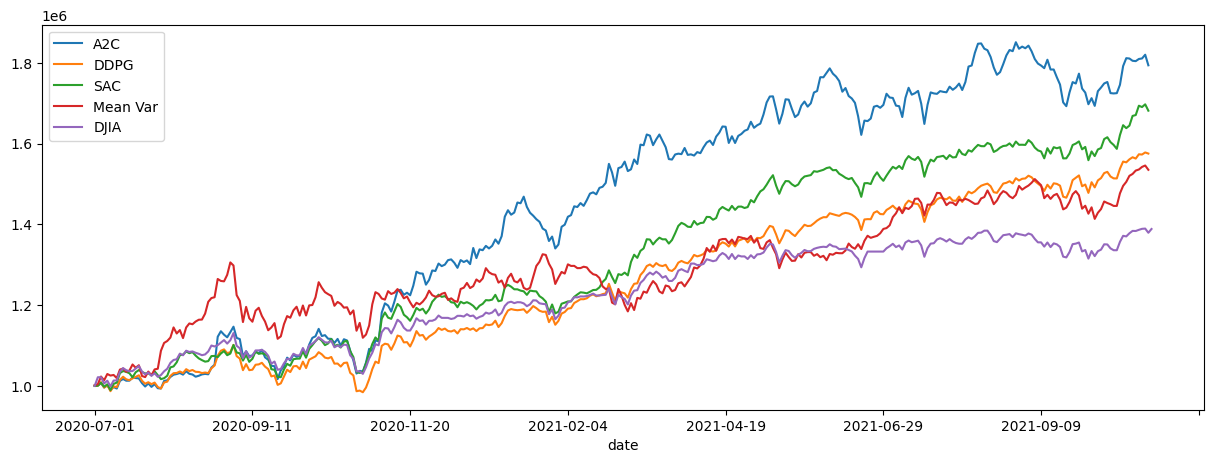

In [151]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure()
result.plot()

# Shell

In [49]:
!pip install colab-xterm
%load_ext colabxterm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
The colabxterm extension is already loaded. To reload it, use:
  %reload_ext colabxterm


In [ ]:
# %xterm